### Create probabilistic forecasts from HRRR using a lagged ensemble and KDE smoothing a la Sobash SS?
The weights of the ensemble members, a bias-correction to observations, and KDE smoothing kernel are hyperparameters to vary

In [1]:
import datetime
import time

%matplotlib inline
import matplotlib as M
import matplotlib.pyplot as plt
from matplotlib import rc
import xarray as xr
import numpy as np

import cartopy.feature as cfeature
from cartopy import crs

from herbie import  FastHerbie, Herbie

from pyart.graph import cm_colorblind

font = {'family' : "helvetica",
        # 'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 12}

rc('font', **font)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


In [2]:
### FUNCTIONS
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

def create_regex(vrbls):
    # qstr = "(:CIMIXR:|:CLMR:)"
    qstr = "("
    for i,v in enumerate(vrbls):
        qstr += f":{v}:"
        if i == len(vrbls):
            qstr += "|"
    qstr += ")"
    return qstr


In [3]:
### SETTINGS

locations_of_interest = [(-109.5287,40.4555),(-110.4029,40.1633),(-109.6774,40.0891),(-109.07315,39.78549),(-110.03689,39.53777),(-110.3728,40.7764)]
names_of_interest = ["Vernal","Duchesne","Ouray","Dragon","Rock Creek Ranch","Kings Peak"]
my_transform = crs.PlateCarree()
my_extent = [-110.6,-108.7,41.05,39.65]
nlines = 5
lonlines = trunc(np.linspace(my_extent[0], my_extent[1], nlines), 1)
latlines = trunc(np.linspace(my_extent[2], my_extent[3], nlines), 1)

coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            edgecolor='black', name='coastline')

counties = cfeature.NaturalEarthFeature(category='cultural', scale='10m',
                            edgecolor='black', name='admin_2_counties_lakes', alpha=0.2)

data_source = "aws"
nprocs = 10

# Set valid time(s)
valid_datetime = datetime.datetime(2023,1,30,12,0,0)
valid_dt_str = datetime.datetime.strftime(valid_datetime, "%Y-%m-%d %H:%M")

# Create ensemble dictionary
# Will have each member (0 to x with x being the earliest init time) as first key
# Each member has "weight", "init_time", "fcst_hr" values
ensemble = dict()

# Set latest init time for forecasts 
latest_init = datetime.datetime(2023,1,30,6,0,0)
latest_dt_str = datetime.datetime.strftime(latest_init, "%Y-%m-%d %H:%M")

latest_fchr = int((valid_datetime - latest_init).total_seconds()/3600)

# Set the gap between lagged forecast init times (int, >0)
hr_spacing = 6

# Initial weighting from earliest to latest
# Could generalise this with function and request number of lagged members
# These weights will eventually be tuned with stochastic gradient descent or something
weighting = [0.3, 0.25, 0.2, 0.15, 0.1]
# weighting = [0.55,0.3,0.15]
num_lags = len(weighting)
assert np.sum(weighting) == 1.0

for x, w in enumerate(weighting):
    ensemble[x] = dict()
    ensemble[x]["weight"] = w
    ensemble[x]["init_time"] = latest_init - datetime.timedelta(hours=int(x*hr_spacing))
    ensemble[x]["fcst_hr"] = int((valid_datetime - ensemble[x]["init_time"]).total_seconds()/3600)

In [4]:
plot_vrbl = "snod"
# Now we can loop over these init_times and forecast hours to download the required variables 
for mem in ensemble.keys():
    fhr = ensemble[mem]["fcst_hr"]
    dt_str = datetime.datetime.strftime(ensemble[mem]["init_time"], "%Y-%m-%d %H:%M")
    if plot_vrbl == "temp":
        FH = FastHerbie([dt_str], model="hrrr", fxx=range(fhr,fhr+1), source=data_source)
        FH.download("TMP:2 m", max_threads=nprocs)
        ds_t2m = FH.xarray("TMP:2 m", remove_grib=True)
        ensemble[mem]["data"] = ds_t2m
    else:
        FH = FastHerbie([dt_str], model="hrrr", fxx=range(fhr,fhr+1), source=data_source, product="sfc")
        FH.download("(:SNOD:)", max_threads=nprocs)
        ds_t2m = FH.xarray("(:SNOD:)", remove_grib=True)
        ensemble[mem]["data"] = ds_t2m
        
    # print(ds_t2m.to_array()[0].max()-273.15)
    ttemps = time.time()

/Users/johnlawson/anaconda3/envs/live-verification/lib/python3.11/site-packages/herbie/core.py:797: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  logic = df.search_this.str.contains(searchString)
/Users/johnlawson/anaconda3/envs/live-verification/lib/python3.11/site-packages/herbie/core.py:1052: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")
/Users/johnlawson/anaconda3/envs/live-verification/lib/python3.11/site-packages/herbie/core.py:797: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  logic = df.search_this.str.contains(searchString)
/Users/johnlawson/anaconda3/envs/live-verification/lib/python3.11/site-packages/herbie/core.py:1052: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.w

In [5]:
def make_plot(ds,fchr,tstr,plot_data=None,plot_vrbl="t2m",cm=None):
    fig, ax = plt.subplots(1, figsize=[7,5], constrained_layout=True, dpi=200,
                      subplot_kw={'projection' : ds.herbie.crs})
    
    if plot_data is None:
        if "step" in ds.dims:
            # plot_data = ds.isel(step=fchr).t2m - 273.15
            plot_data = ds.isel(step=fchr).sde
        else:
            # plot_data = ds.t2m - 273.15
            plot_data = ds.sde 
    else:
        print("Plotting custom data.")
    #Plot 2m temperature, usually
        
    if plot_vrbl == "auto":
        pc_temp = ax.pcolormesh(ds.longitude,  ds.latitude, 
                                plot_data, vmin=0, vmax=0.5, alpha=0.7,
                                cmap=cm_colorblind.HomeyerRainbow,
                                transform=my_transform)
    elif isinstance(plot_vrbl,(list,tuple)):
        if cm is not None:
            cmap = cm
        else:
            cmap = cm_colorblind.SpectralExtended
        pc_temp = ax.pcolormesh(ds.longitude,  ds.latitude, 
                                plot_data, vmin=plot_vrbl[0], vmax=plot_vrbl[1], alpha=0.7,
                                cmap=cm,
                                transform=my_transform)
    elif plot_vrbl == "temp":
        pc_temp = ax.pcolormesh(ds.longitude,  ds.latitude, 
                                plot_data, vmin=0.001, vmax=1, alpha=0.7,
                                cmap=cm_colorblind.HomeyerRainbow,
                                transform=my_transform)
    elif plot_vrbl == "snod":
        pc_temp = ax.pcolormesh(ds.longitude,  ds.latitude, 
                                plot_data, vmin=0.001, vmax=0.25, alpha=0.7,
                                cmap=M.cm.Purples,
                                transform=my_transform)
        
    c1 = plt.colorbar(pc_temp, fraction=0.046, pad=0.04)
    # c1.set_label(label='2m Temperature (Celsius)', size=18, weight='bold')
    c1.ax.tick_params(labelsize=18) 
    
    
    #Zoom
    ax.set_extent(my_extent, crs=my_transform)
    
    #Gridlines
    gl1 = ax.gridlines(xlocs=lonlines, ylocs=latlines, x_inline=False, rotate_labels=False)
    gl1.xlabels_bottom = True
    gl1.ylabels_left = True
    gl1.xlabel_style = {'size': 18}
    gl1.ylabel_style = {'size': 18}
    if tstr is not None:
        ax.set_title(tstr, loc="left")
    
    #Map features
    ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='black')
    ax.add_feature(coast, facecolor='none', edgecolor='black')
    ax.add_feature(counties, facecolor='none', edgecolor='black')
    
    #Plot Locations
    ax.scatter([loc[0] for loc in locations_of_interest],
                [loc[1] for loc in locations_of_interest], transform=my_transform, marker='o', color='r')
    
    for i in range(len(names_of_interest)):
        ax.text(locations_of_interest[i][0],locations_of_interest[i][1], 
                 names_of_interest[i], transform = my_transform, size=15 )
    return fig

/Users/johnlawson/anaconda3/envs/live-verification/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/Users/johnlawson/anaconda3/envs/live-verification/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/Users/johnlawson/anaconda3/envs/live-verification/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/Users/johnlawson/anaconda3/envs/live-verification/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:475: UserWarning

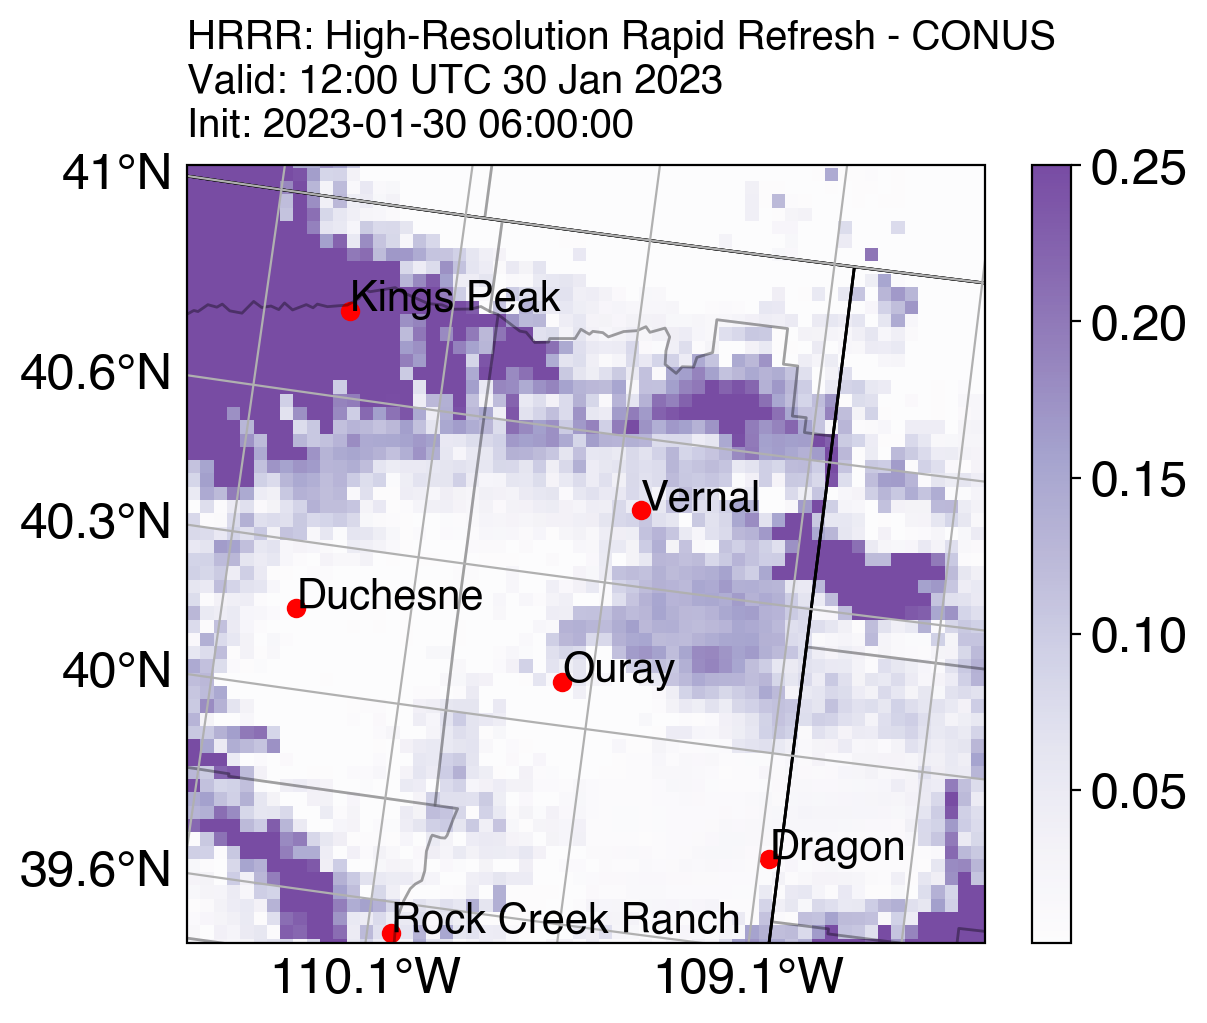

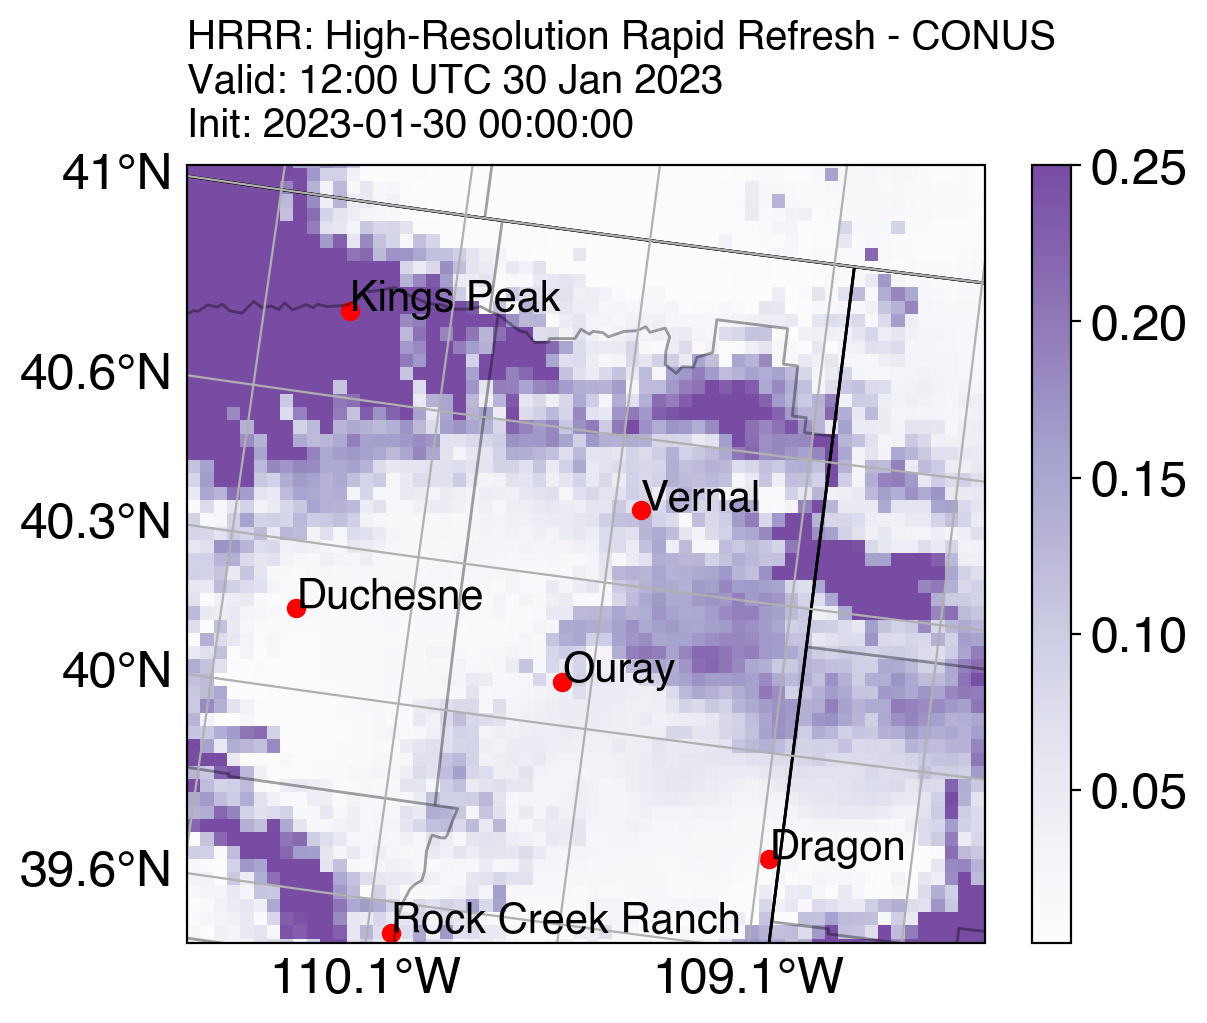

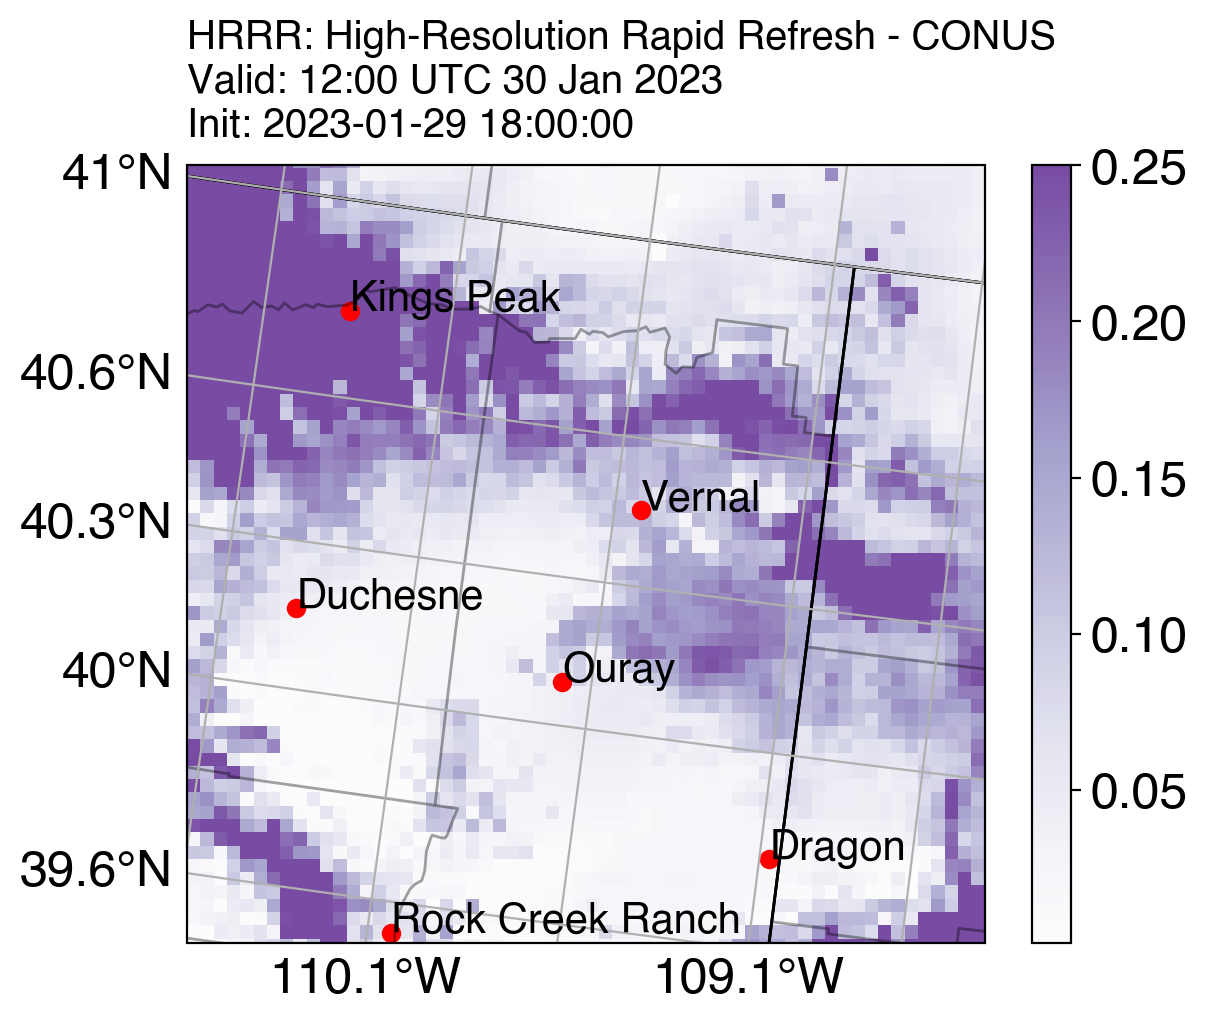

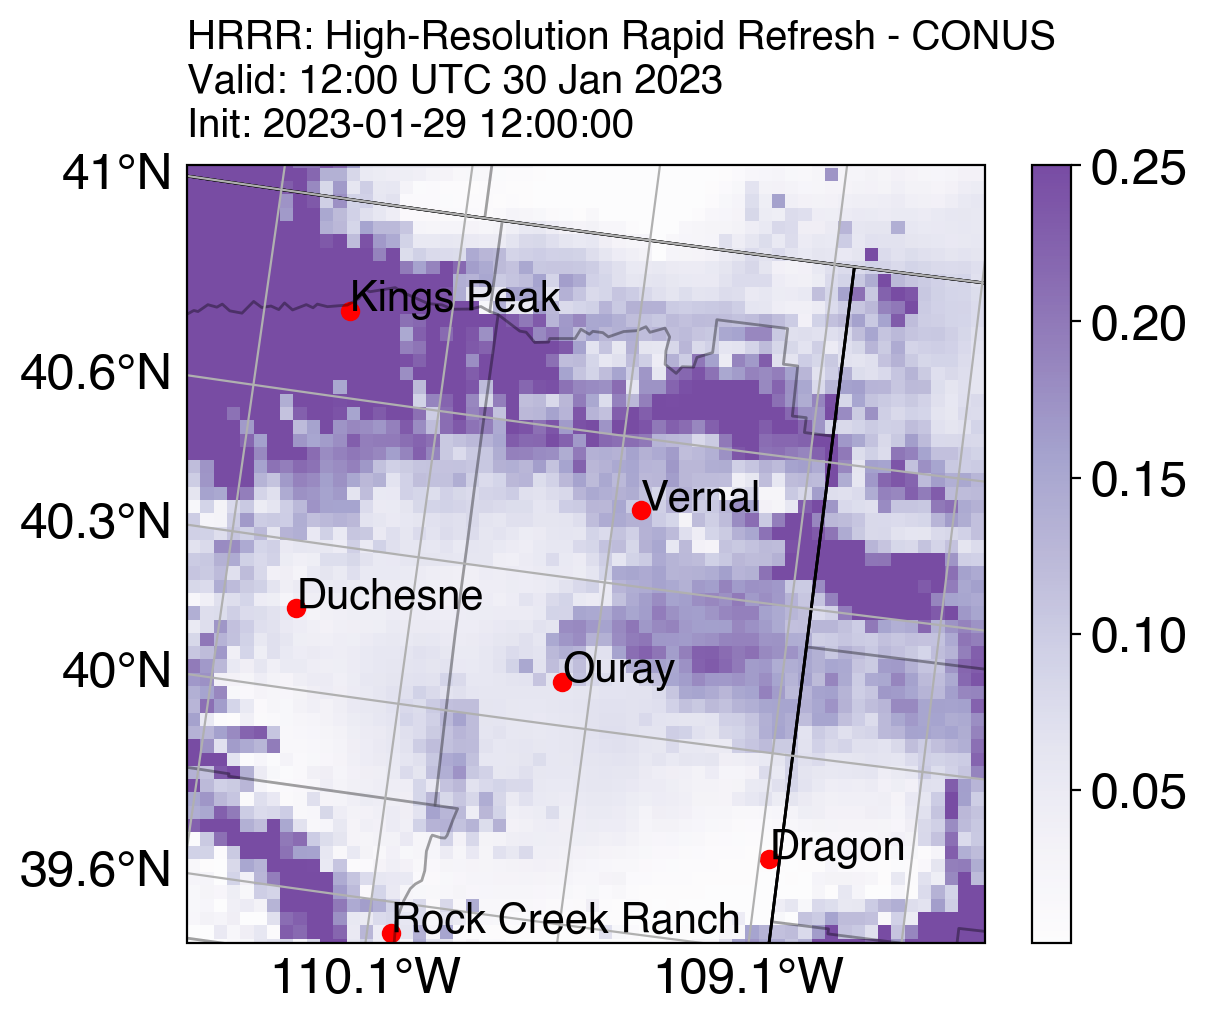

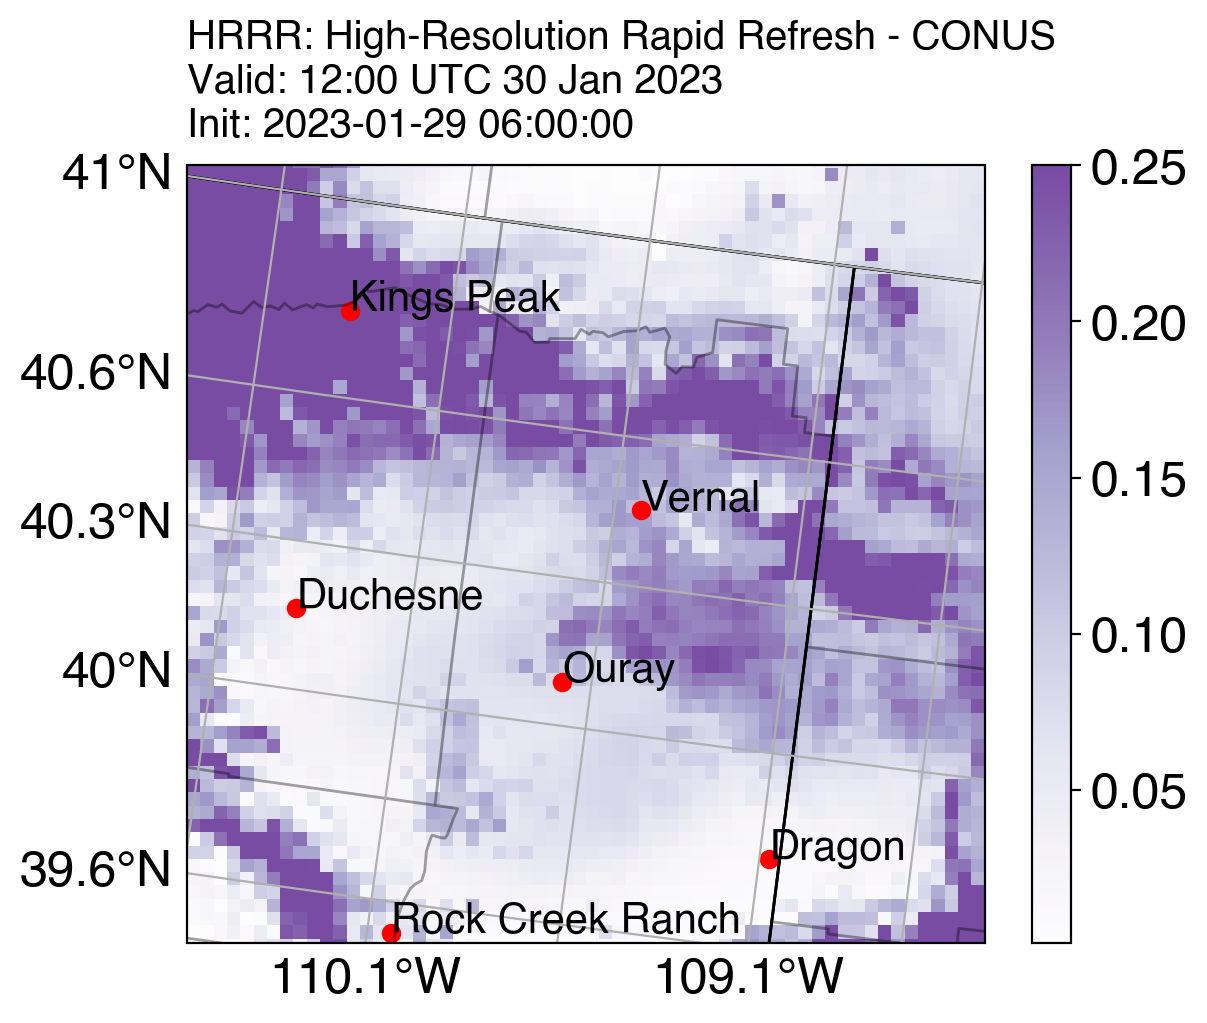

In [6]:
if plot_vrbl == "temp":
    xsize = len(ensemble[mem]["data"].t2m.x)
    ysize = len(ensemble[mem]["data"].t2m.y)
elif plot_vrbl == "snod":
    xsize = len(ensemble[mem]["data"].sde.x)
    ysize = len(ensemble[mem]["data"].sde.y)

stack_data = np.zeros([num_lags,ysize,xsize])
for mem in sorted(ensemble.keys()):
    # print(f"{mem=}")
 
    ds = ensemble[mem]["data"]
    # tstr = f"{ds.model.upper()}: {ds.description}\nValid: {ds.valid_time[ensemble[mem]['fcst_hr']].dt.strftime('%H:%M UTC %d %b %Y').item()}"
    tstr = f"{ds.model.upper()}: {ds.description}\nValid: {ds.valid_time.dt.strftime('%H:%M UTC %d %b %Y').item()}\nInit: {ensemble[mem]['init_time']}"

    f = make_plot(ensemble[mem]["data"],ensemble[mem]["fcst_hr"],tstr,plot_vrbl="snod")
    dd = ensemble[mem]["data"].to_array()[0]
    if plot_vrbl == "temp":
        dd -= 273.15
    stack_data[mem,:,:] = dd


Plotting custom data.


/Users/johnlawson/anaconda3/envs/live-verification/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/Users/johnlawson/anaconda3/envs/live-verification/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


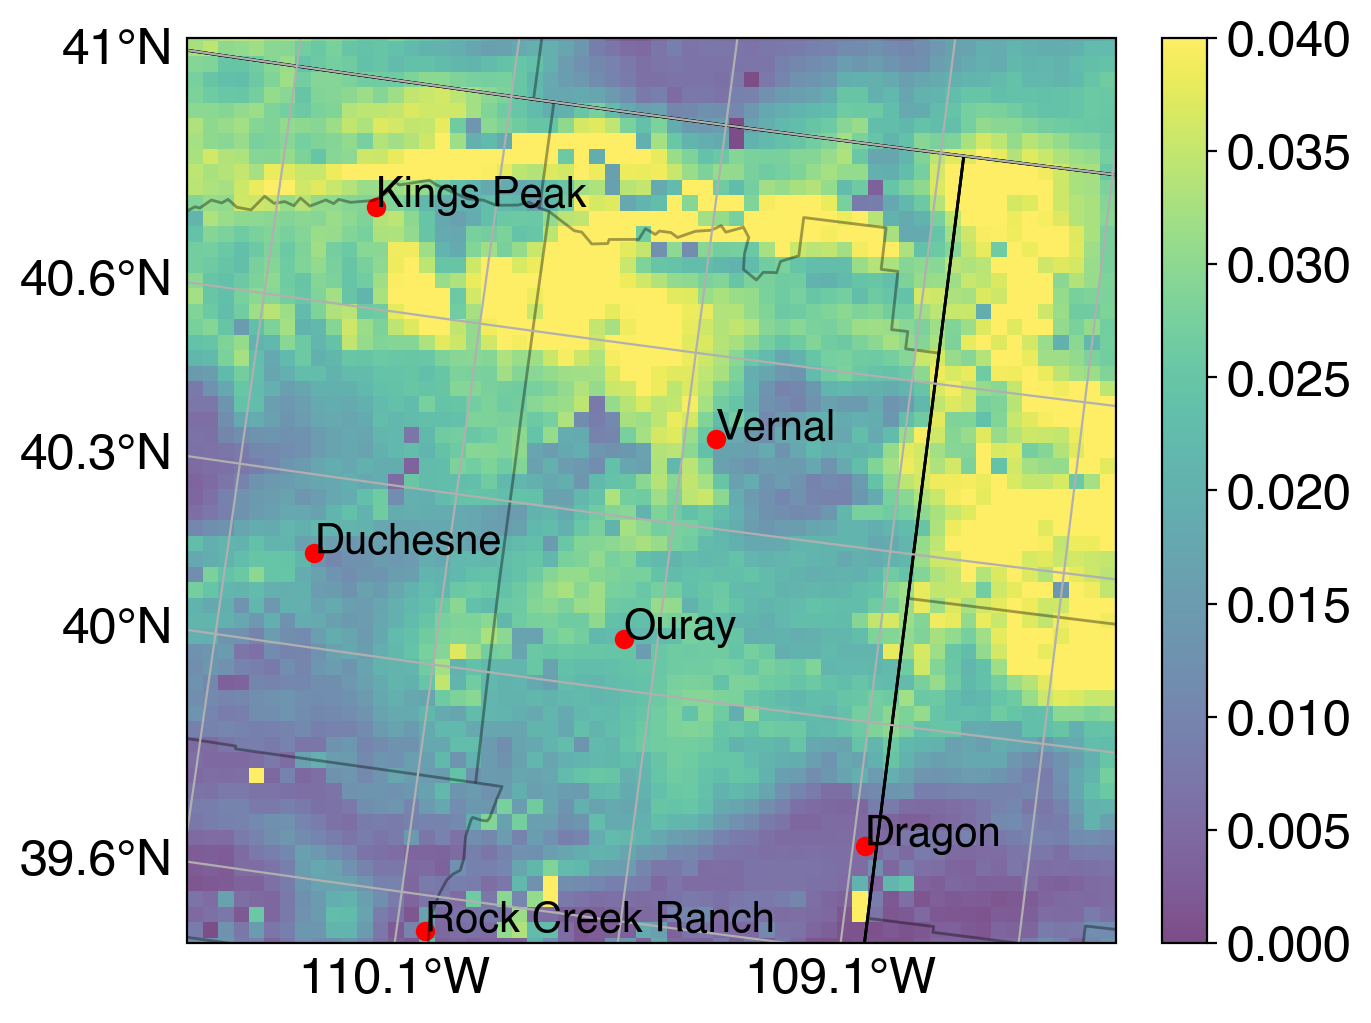

In [7]:
std_data = np.std(stack_data, axis=0)
fig = make_plot(ds_t2m,None,None,plot_data=std_data, plot_vrbl=[0,0.04])

Plotting custom data.


/Users/johnlawson/anaconda3/envs/live-verification/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/Users/johnlawson/anaconda3/envs/live-verification/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


Plotting custom data.


/Users/johnlawson/anaconda3/envs/live-verification/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/Users/johnlawson/anaconda3/envs/live-verification/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


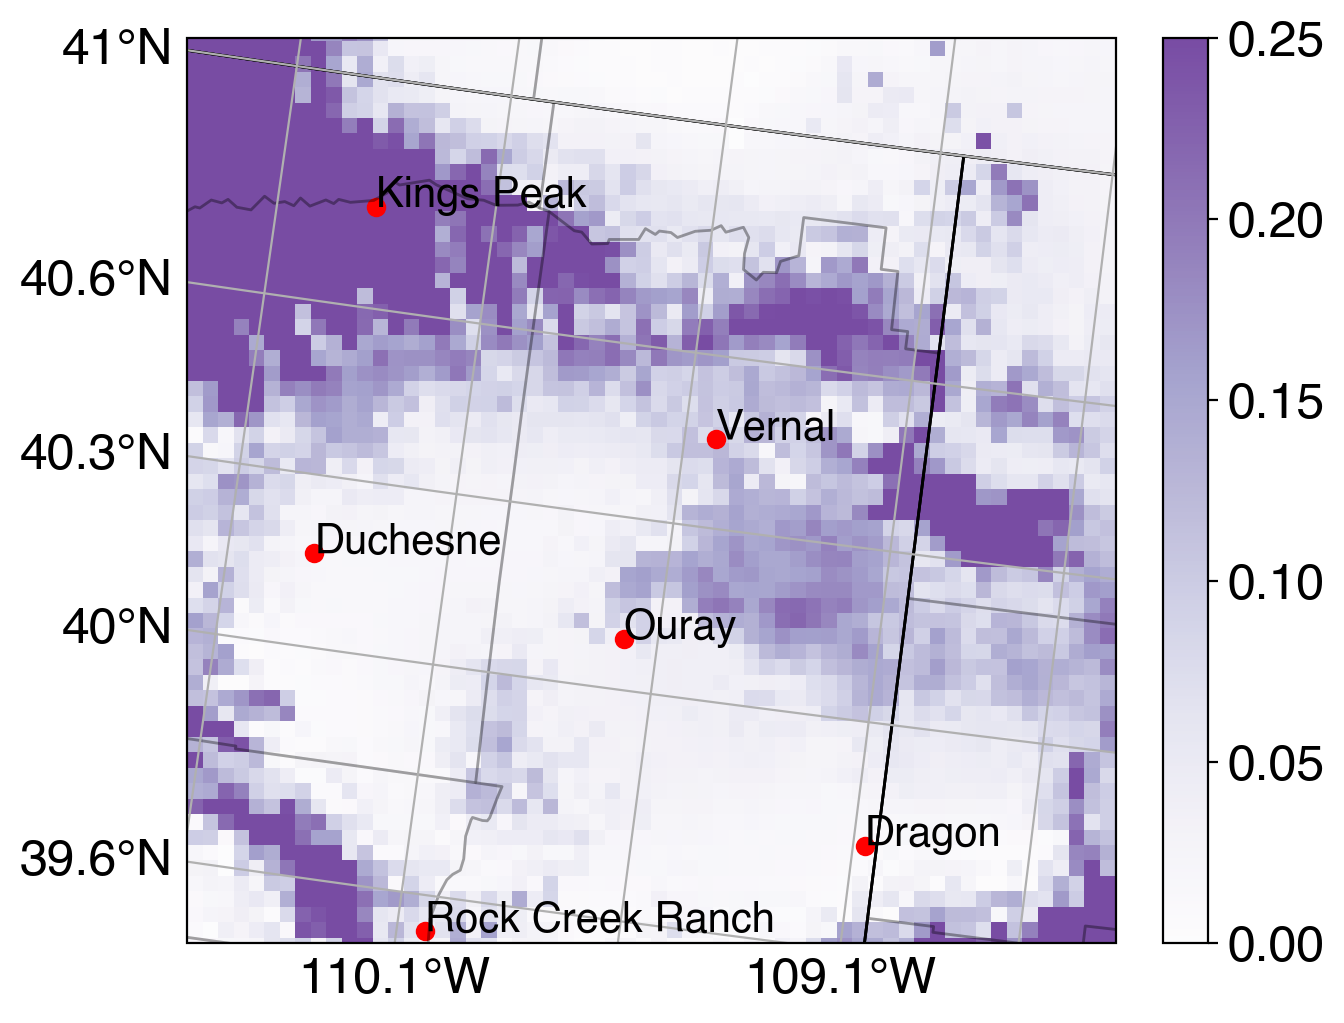

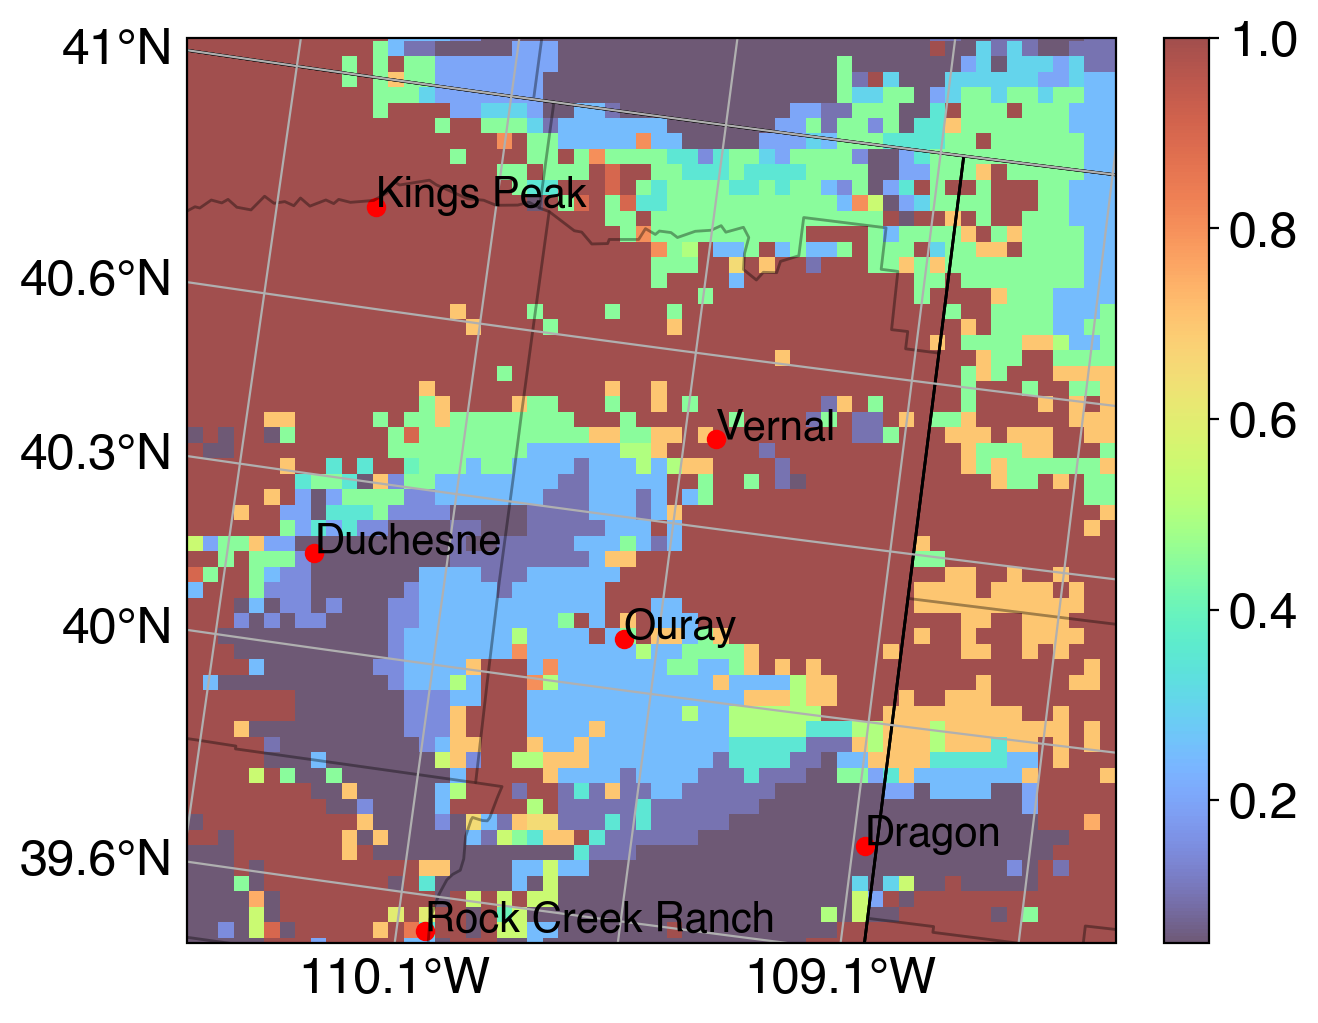

In [8]:
# Create mean and probabilities of exceedence with weighting
weighted_ave = np.average(stack_data, axis=0, weights=weighting)
fig = make_plot(ds_t2m,None,None,plot_data=weighted_ave, plot_vrbl=[0,0.25],cm=M.cm.Purples)

exceed_data = np.where(stack_data >= 0.05)
exceed_data2 = np.zeros_like(stack_data)
exceed_data2[exceed_data] = 1
exceed_data2 = exceed_data2.reshape(stack_data.shape)
weighted_probs = np.average(exceed_data2, axis=0, weights=weighting)
fig = make_plot(ds_t2m,None,None,plot_data=weighted_probs, plot_vrbl=[0.05,1], cm=M.cm.turbo)


In [9]:
# Verify vs. obs and fcsts

# We don't have snow depth observed?

# Can do the same for things like 2m temp, etc (ensemble mean "most likely", and weighted probabilities)

In [10]:
ds_2 = ds_t2m.set_coords(dict(latitude = (["y","x"], ds_t2m.latitude.values,
                                                        {'units':'degrees_north'}),
                                            longitude = (["y","x"], ds_t2m.longitude.values, 
                                                         {'units':'degrees_east'}),))
# coords=dict(latitude = (["south_north","west_east"], ds_out.latitude.values,
#                                                         {'units':'degrees_north'}),
#                                             longitude = (["south_north","west_east"], ds_out.longitude.values, 
#                                                          {'units':'degrees_east'}),
ds_2.sel(latitude=43.2,longitude=-111.1)

KeyError: "no index found for coordinate 'latitude'"